In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import pystan
from datetime import datetime, timedelta

from time import sleep
import os
from IPython.display import display

%matplotlib inline 

In [3]:
%load_ext autoreload
%autoreload 2

from functions.helper_functions import (StanModel_cache,
                                        vb, model_dict,
                                        get_sector_assignment_dict,)

run_in_parallel = False

<h3>Run the following cell, if you want to run different models in parallel, otherwise skip the cell.</h3>
<p>Before running the cell, start clusters. E.g. run 'ipcluster start -n 4'.</p>
<p>More information on: https://ipyparallel.readthedocs.io/en/latest/intro.html#getting-started </p>

In [4]:
import ipyparallel as ipp

rc = ipp.Client()
dview = rc.load_balanced_view()

with rc[:].sync_imports():
    import numpy as np
    import pandas as pd
    import pystan
    
    from functions.helper_functions import (vb, model_dict)
print(rc.ids)

run_in_parallel = True

importing numpy on engine(s)
importing pandas on engine(s)
importing pystan on engine(s)
importing vb,model_dict from functions.helper_functions on engine(s)
[0, 1, 2, 3]


<h1>Load Data</h1>

In [5]:
N = 60  # max: 120

data = pd.read_csv('example_data/stock_data_17_18.csv', index_col='Date', parse_dates=['Date']).iloc[:,:N]
sector_assignments = pd.read_csv('example_data/sector_assignments_17_18.csv', index_col=0).values.squeeze()[:N]

stock_list = data.columns

print( "number of nan's: {}".format(data.isna().sum().sum()) )
print( "shape data: {}".format(data.shape) )
display(data.head())

number of nan's: 0
shape data: (250, 60)


,SNPS,HOG,TGT,JBHT,C,GPN,DOV,ITW,CL,PLD,...,PPG,DLPH,CME,CBOE,PNC,SYY,CINF,FCX,DXC,CBS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,0.003369,0.011028,0.014571,0.010850,0.013533,0.037305,0.004711,0.003836,0.010986,0.017803,...,0.021207,0.037015,0.009790,0.039310,0.008477,0.009146,0.003694,0.076197,0.038045,0.020966
2017-01-05,0.003693,0.001007,-0.016935,-0.006440,-0.017424,0.003966,-0.003256,-0.011220,0.008904,0.000372,...,-0.016963,-0.006140,0.003463,-0.010411,-0.013365,-0.003263,-0.004075,-0.014160,-0.002522,-0.003955
2017-01-06,0.003512,-0.009221,-0.015435,0.005144,0.003480,0.014029,0.015550,0.010443,0.007629,0.006510,...,-0.000314,-0.006321,0.010956,0.005460,0.014227,0.007092,0.000264,0.019152,0.010113,-0.018174
2017-01-09,0.001333,-0.016074,-0.000140,-0.008394,-0.005450,0.071726,-0.012867,-0.004883,-0.013955,-0.007577,...,0.007951,-0.016047,-0.007339,-0.012848,-0.007140,0.005417,-0.016891,-0.014765,-0.002002,-0.012599
2017-01-10,0.010153,0.006019,0.000000,0.008775,0.000166,-0.023938,0.003910,0.002372,-0.015507,-0.022905,...,0.000415,0.035410,-0.000258,-0.011405,0.003976,-0.006286,0.000268,0.059264,0.012372,-0.012445


<h1>Compile Stan Code</h1>

In [6]:
file = "functions/stan_gplvm_finance.stan"
with open(file) as f:
    stan_code = f.read()

stan_model = StanModel_cache(model_code=stan_code)

Using cached StanModel


<h1>Train Model</h1>

In [7]:
def run_calc(model_name, Q, num):
    #shared variables: N, D, Y, model_dict, stan_model, tries
    import pandas as pd
    data_dict = {'N':N, 'D':D, 'Q':Q, 'Y':Y, 'model_number':model_dict[model_name]}
    n_error, should_break, n_error_max = 0, False, 5
    while n_error<n_error_max:    # sometimes, bad initialization leads to RuntimeError, 
                                  # if more then 5 times: break.
        try:
            diagnostic, sample = vb(data_dict, stan_model, tries=tries, num=num)
            n_error = n_error_max
        except RuntimeError:
            n_error += 1
            if n_error == n_error_max: should_break = True
            print('RuntimeError')

    if should_break:
        print('RuntimeError occurred too often.')
        return None
    elbo = diagnostic.loc[:, 'ELBO'].values[-1]
    X = sample.filter(regex='^X.\d{1,4}.\d{1,3}$') \
                .mean(axis=0).values.reshape(Q, N).T
    r2 = sample.filter(regex='^R2_hat_N$').mean(axis=0).values.squeeze()
    lengthscale = sample.filter(regex='^kernel_lengthscale$')\
        .mean(axis=0).values.squeeze()
    
    #print('elbo:{}\nr2:{}\nlengthscale:{}'.format(elbo, r2, lengthscale))
    #col_names = ['model_name', 'Q', 'ELBO', 'R2', 'inv_lengthscale']
    #df = pd.DataFrame({num: (model_name, Q, elbo, r2, inv_lengthscale)}, index=col_names).T
    return model_name, elbo, X

<h2>Specify parameter</h2>
<p>to get a better convergence, increase 'tries'. Note that $Y \in \mathbb{R}^{N \times D}$ is data.T</p>

In [8]:
Y = data.T.values
N, D = Y.shape
tries = 20
Qs = [2,]

model_names = ['linear', 'squared_exp', 'exp', 'matern32']

inp = [(model_name, Q) for model_name in model_names for Q in Qs]

randint = np.random.randint(0, 1e+10)       
inp = [[*el, i+randint] for i, el in enumerate(inp)]
print('number inputs: {}'.format(len(inp)))

number inputs: 4


<hr>
<h4>If ipyparallel is imported the runs are distributed among all CPUs
otherwise inp-list is processed sequentially</h4>
<p>Note: if the list of inputs is too long and you not running ipyparallel, it might take a lot of time</p>

In [9]:
%%time
if run_in_parallel:
    async_res = []
    ids = []

    rc[:].push(dict(N=N, D=D, Y=Y, stan_model=stan_model, tries=tries,), block=True)

    for param in inp:
        re = dview.apply_async(run_calc, *param)
        async_res.append(re)
        ids.extend(re.msg_ids)

    # display progress
    sleep(10)
    while True:
        print(str(len(rc.result_status(ids)['pending'])) +"/"
              +str(len(rc.result_status(ids)['pending'])
                   +len(rc.result_status(ids)['completed']))
              +" still running. on " + str(len(rc.ids)) + " cores", end="\r")
        sleep(10)
        if len(rc.result_status(ids)['pending']) == 0: break
    
    
    # collect results 
    results = [r.get() for r in async_res]
    
    
else:
    # to get rid of the stan-warnings comment out the warning lines (second and 
    # third last line) in the pystan source code (file: pystan/model.py - vb() )
    # if you use a pickled model - recompile it after commenting out the lines
    
    results = []
    print('starting calculations ...', flush=True)
    for i, inp_ in enumerate(inp):
        results.append( run_calc(*inp_) )
        print('{}% done'.format( int(100*(i+1)/len(inp)) ), end='\r', flush=True)


CPU times: user 832 ms, sys: 116 ms, total: 948 ms
Wall time: 30min 12s


<h4>Display Results</h4>
<p>Only works for $Q=2$</p>

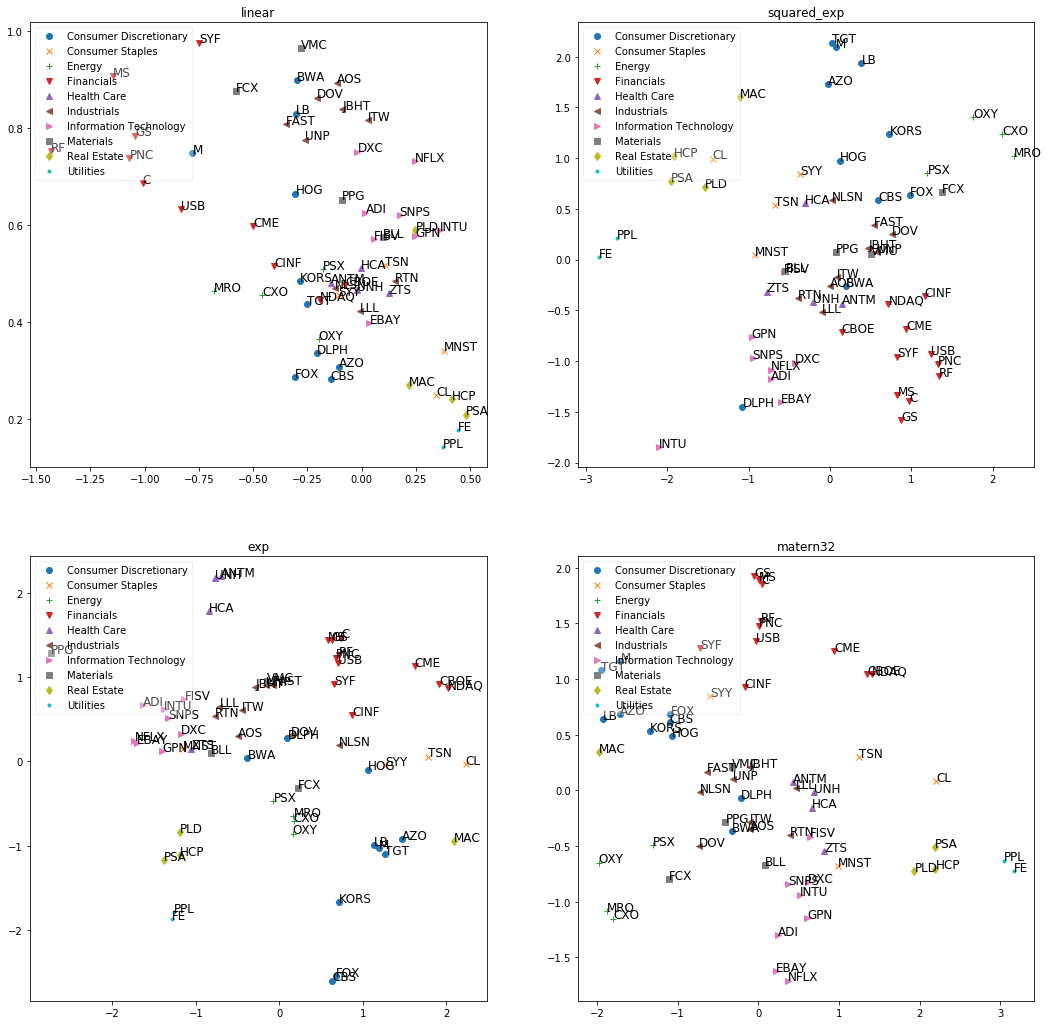

In [10]:
N_models = len(model_names)
fig = plt.figure(figsize=(9*N_models/2,18))
marker = ['o', 'x', '+', 'v', '^', '<', '>', 's', 'd', '.', ',']

for i, (model_name, _, X) in enumerate(results):
    df_X = pd.DataFrame(X, index=stock_list, columns=['X1', 'X2'])
    df_X['Sector'] = sector_assignments

    ax = fig.add_subplot(N_models/2,2,i+1)
    for i, (group_name, group_df) in enumerate(df_X.groupby(by='Sector')):
        ax.plot(group_df.loc[:, 'X1'], group_df.loc[:, 'X2'], marker[i], label="{}".format(group_name))

    for j,stock in enumerate(df_X.index):
        ax.annotate(stock, df_X.iloc[j, [0,1]], fontsize=12)
        
    ax.set_title(model_name)
    plt.legend(numpoints=1, framealpha=0.3, loc=2)
        
plt.show()